# Correlation Functions

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import camb
import hankl
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=16)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, get_xi_from_P, power_multipoles

In [6]:
# modes to sample
nmodes = 512
kmin = 1e-5
kmax = 1e+2
aexp=1.0 #0.01


# list of parameters with respect to which we take derivatives

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
mnu     = 0.06  #eV
Neff    = 3.046 # -1 if massive neutrino present
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822

fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'w_0', '(1+w_a)', 'n_s']#, 'w_0', 'w_a', 'c_s^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, N_nu_rel, mnu, Tcmb, w_DE_0, 1+w_DE_a, n_s,])#  w_DE_0, w_DE_a, cs2_DE])

def xi_RSD_of_cosmo( args ):
  param = {}
  param['Omegam'] = args[1]
  param['Omegab'] = args[2]
  param['OmegaDE'] = 1-args[1]
  param['Omegak'] = 0.0
  param['A_s'] = A_s
  param['n_s'] = args[8]
  param['H0'] = args[0]
  param['Tcmb'] = args[5]
  param['YHe'] = YHe
  param['Neff'] = args[3]
  param['Nmnu'] = N_nu_mass
  param['mnu'] = args[4]
  param['w_DE_0'] = args[6]
  param['w_DE_a'] = args[7]-1
  param['cs2_DE'] = 1.0
  param['k_p'] = 0.05

  ## compute the background evolution
  param = evolve_background(param=param)  
  y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, 
                aexp_out=jnp.array([1.0]), rtol=1e-4, atol=1e-4 )

  P0, P2, P4 = power_multipoles( y=y[:,-1,:], kmodes=kmodes, b=2.0, param=param )

  xi0, r = get_xi_from_P( k=kmodes, Pk=P0, N=nmodes, ell=0 )
  xi2, r = get_xi_from_P( k=kmodes, Pk=P2, N=nmodes, ell=2 )
  xi4, r = get_xi_from_P( k=kmodes, Pk=P4, N=nmodes, ell=4 )

  return jnp.array([xi0,xi2,xi4]), r


In [7]:
## compute xi
y,r  = xi_RSD_of_cosmo( fiducial_cosmo_param )

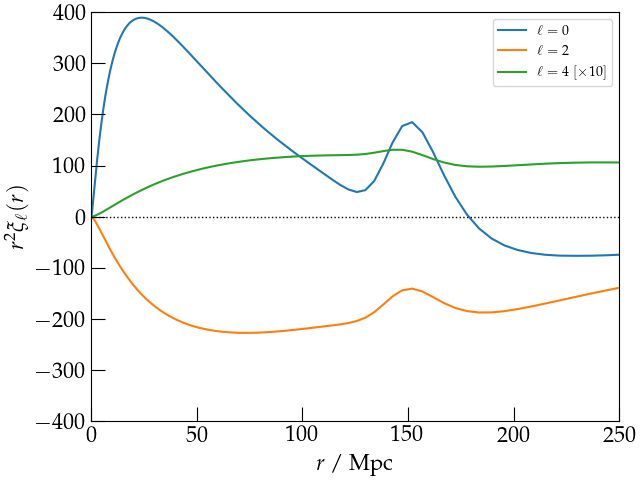

In [13]:
fig, ax = plt.subplots( layout='constrained')

xi0 = y[0,:]
xi2 = y[1,:]
xi4 = y[2,:]

ax.plot( r, r**2 *  xi0, label=f'$\\ell=0$' )
ax.plot( r, r**2 *  xi2, label=f'$\\ell=2$' )
ax.plot( r, r**2 *  xi4 * 10, label=f'$\\ell=4$ $[\\times 10]$' )

ax.axhline( 0.0, lw=1, ls=':', c='k')
# ax.plot( r*h, (r*h)**2 *  xi4 )

ax.set_xlim(0,250)
ax.set_ylim(-400,400)
# ax.semilogx()

ax.set_xlabel('$r$ / Mpc')
ax.set_ylabel('$r^2 \\xi_\\ell(r)$')
ax.legend()

In [9]:
## compute derivative
dy,_ = jax.jacfwd(xi_RSD_of_cosmo)(fiducial_cosmo_param)

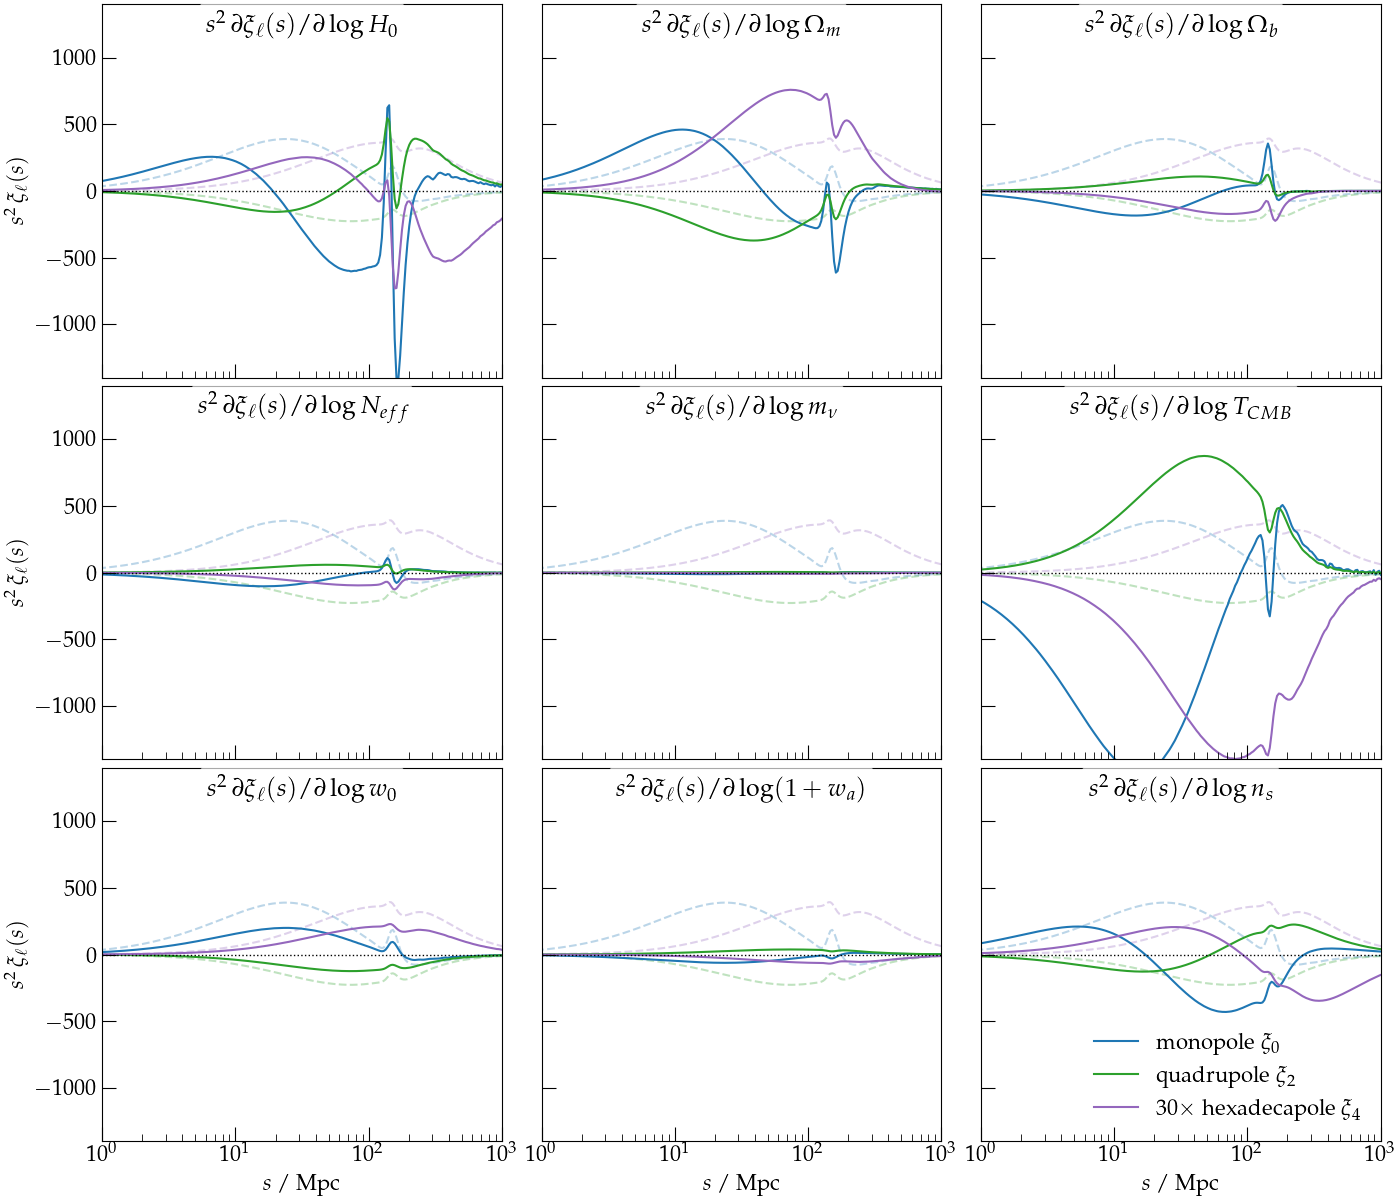

In [14]:
## make the plot
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -20  # pad is in points...

fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(14,12),layout='constrained')#, gridspec_kw={'height_ratios': [2,1,2,1,2,1,2,1]})

title_bbox = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.667)
lw = 1.5
for i in range(9):
  iy = i%3
  ix = i//3
  ax[ix,iy].plot( r, r**2 * jnp.real(xi0), c='C0', ls='--', alpha=0.3, lw=lw )
  ax[ix,iy].plot( r, r**2 * jnp.real(xi2), c='C2', ls='--', alpha=0.3, lw=lw )
  ax[ix,iy].plot( r, r**2 * jnp.real(xi4) * 30, c='C4', ls='--', alpha=0.3, lw=lw )

  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[0,:,i]), label=f'monopole $\\xi_0$', c='C0', lw=lw )
  # ax[ix,iy].plot( r, r**2 * xi0, c='C0', alpha=0.3 )
  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[1,:,i]), label=f'quadrupole $\\xi_2$', c='C2', lw=lw )
  # ax[ix,iy].plot( r, r**2 * xi2, c='C2', alpha=0.3 )
  # ax[ix,iy].plot( r, r**2 * dy[2,:,i], label=f'hexadecapole $\\xi_4$', c='C4' )
  # ax[ix,iy].plot( r, r**2 * xi4, c='C4', alpha=0.3 )

  ax[ix,iy].plot( r, r**2 * fiducial_cosmo_param[i] * jnp.real(dy[2,:,i]) * 30, label=f'30$\\times$ hexadecapole $\\xi_4$', c='C4', lw=lw )

  ax[ix,iy].set_title(f'$s^2\\,\\partial  \\xi_{{\\ell}}(s) / \\partial \\log {fieldnames[i]}$', bbox=title_bbox, fontsize=18)

for a in ax.flatten():
  a.semilogx()
  a.axhline( 0.0, lw=1, ls=':', c='k')
  a.set_xlim(1,1e3)
  a.set_ylim(-1400,1400)

for a in ax[-1,:]:
  a.set_xlabel('$s$ / Mpc')

for a in ax[:,0]:
  a.set_ylabel('$s^2\,\\xi_{{\\ell}}(s)$')

ax[-1,-1].legend(loc='lower right', fontsize=16, frameon=False)

plt.savefig('derivative_correlation_function.pdf',bbox_inches='tight')